#**InSpectral**

SER-347: Introdução à programação para sensoriamento remoto

Projeto final de disciplina

&nbsp;

Discentes: Ana Clara da Cruz Silva; Carina Inácio Portela; Rafael Grinberg Chasles.


### ABOUT THE PROJECT

**Theme**

Biblioteca de índices espectrais em Python.

&nbsp;

**Goal**

O objetivo desse projeto é construir uma ferramenta em Python para computação de índices espectrais para análises ambientais, a partir de imagens de sensoriamento remoto. Desenvolver um programa para demonstrar seu uso com dados disponíveis no Brazil Data Cube. Dos satélites Landsat 8(OLI), Sentinel 2(MSI), e Cbers 4(WFI).

&nbsp;

**Requirements**

*   Possibilitar ao usuário informar o tipo de índice a ser computado e o nome dos arquivos contendo as imagens com as bandas espectrais necessárias à criação do índice.
*   Fornecer ao usuário informações dos métodos suportados pela ferramenta, incluindo a listagem completa dos índices disponíveis e informações detalhadas sobre um índice em particular.
*   Integrar com a biblioteca NumPy, permitindo a computação de índices a partir de matrizes bidimensionais com valores das bandas espectrais necessárias.
*   Apresentar informações sobre os índices na forma de elementos gráficos apropriados.
*   Desenvolver uma ferramenta na forma de um pacote Python chamado InSpectral.
*   Fornecer uma interface de linha de comando para as funcionalidades deste pacote.




####**General code structure**
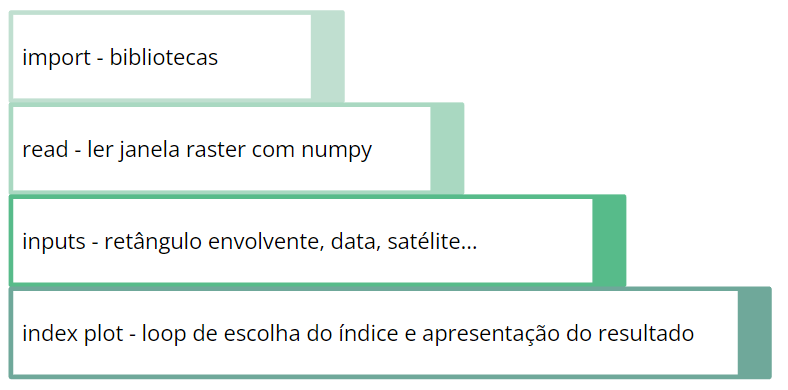


### LIBS

In [ ]:
import os
os.environ["CURL_CA_BUNDLE"]='/etc/ssl/certs/ca-certificates.crt'

!pip install pystac-client==0.3.2 rasterio shapely matplotlib tqdm
!pip install folium==0.2.1
!pip install jenkspy

import pystac_client
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform
from rasterio.windows import from_bounds
from matplotlib import pyplot as plt
from rasterio.plot import show
import numpy as np
from osgeo import gdal
import jenkspy

#conecção com BDC
parameters = dict(access_token='jeXchZiqYZ5I1ybxouubE1E0K58IHwY55rNp1vD2O5')
service = pystac_client.Client.open('https://brazildatacube.dpi.inpe.br/stac/', parameters=parameters)

###READ

In [ ]:
#ler janela raster com numpy
def read(uri: str, bbox: list, masked: bool = True, crs: str = None):
    """Read raster window as numpy.ma.masked_array."""
    source_crs = CRS.from_string('EPSG:4326')
    if crs:
        source_crs = CRS.from_string(crs)

    # Expects the bounding box has 4 values
    w, s, e, n = bbox
        
    with rasterio.open(uri) as dataset:
        transformer = transform(source_crs, dataset.crs, [w, e], [s, n])
        window = from_bounds(transformer[0][0], transformer[1][0], 
                             transformer[0][1], transformer[1][1], dataset.transform)
        return dataset.read(1, window=window, masked=masked)        

## INPUTS

### BBOX, DATE, SATELLITE AND IMAGE


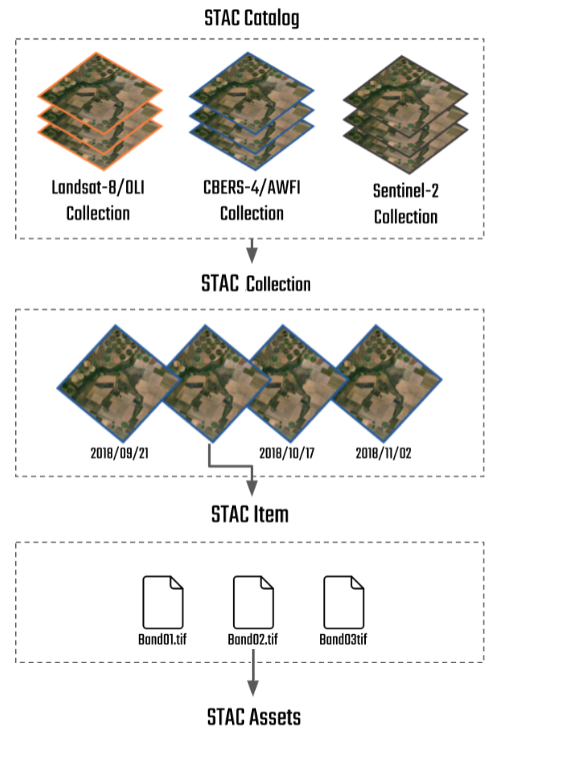

In [ ]:
#INPUT DO USUÁRIO

print('RETÂNGULO ENVOLVENTE')

xmin = float(input('Coloque coordenada oeste -> ')) # -46.12
ymin = float(input('Coloque coordenada sul -> ')) # -23.23
xmax = float(input('Coloque coordenada leste -> ')) # -45.95
ymax = float(input('Coloque coordenada norte -> ')) # -23.16

#xmin = -46.12
#ymin = -23.23
#xmax = -45.95
#ymax = -23.16

bbox = (xmin, ymin, xmax, ymax)


date = input('Coloque o intervalo de data em AAAA-MM-DD/AAAA-MM-DD: ', ) 
#date = ('2020-01-01/2020-12-31')

#loop de escolha de imagem 
opc = 's' #opção sim

res = 'NaN' #opção diferente de sim

while opc.lower() == 's':
  
  print('Escolha entre as coleções abaixo:')

  print("CB4_64_16D_STK-1 \n"
        "LC8_30_16D_STK-1 \n"
        "S2_L2A-1 \n")

  #escolhendo o satélite
  colecao = [str(input('Copie e cole o satélite/sensor que quer observar: ', ))] #LC8_30_16D_STK-1
  colecao

  #estabelecendo um limite de imagens para escolha
  limite = int(input('Até quantas imagens gostaria de observar? ', )) #10

  #criando os items
  item_search = service.search(bbox=bbox,
                              datetime=date,
                              collections=colecao,
                              max_items=limite)
  item_search

  items = list(item_search.get_items())

  #escolhendo a imagem que quer calcular os indices
  print('Escolha da lista abaixo a imagem que deseja calcular o índice (primeiro item é 0)')
  for item in item_search.get_items():
      print(item)

  #usuario escolhe a opção da lista apresentada
  img_choice = int(input('Escolha qual imagem da lista acima quer visualizar (0 - n). Obs.: primeira imagem inicia em zero: ')) #8

  assets = item.assets

  item = items[img_choice]
  item


  #Leitura de banda para cada satélite
  ##Landsat 8
  if  colecao == ['LC8_30_16D_STK-1']:
    red_band = read(item.assets['band4'].href, bbox=bbox)
    nir_band = read(item.assets['band5'].href, bbox=bbox)
    green_band = read(item.assets['band2'].href, bbox=bbox)
    blue_band = read(item.assets['band3'].href, bbox=bbox)
    
    
    ##Sentinel 2
  if colecao == ['S2_L2A-1']:
    red_band = read(item.assets['B04'].href, bbox=bbox)
    nir_band = read(item.assets['B08'].href, bbox=bbox)
    green_band = read(item.assets['B03'].href, bbox=bbox)
    blue_band = read(item.assets['B02'].href, bbox=bbox)

    #CBERS 4
  if colecao == ['CB4_64_16D_STK-1']:
    red_band = read(item.assets['BAND15'].href, bbox=bbox)
    nir_band = read(item.assets['BAND16'].href, bbox=bbox)
    green_band = read(item.assets['BAND14'].href, bbox=bbox)
    blue_band = read(item.assets['BAND13'].href, bbox=bbox)

  #plot rgb imagem de consulta
  linhas = blue_band.shape[0]
  colunas = blue_band.shape[1]
  gain = 1.8

  array_rgb = np.zeros((linhas, colunas, 3))

  array_rgb[:, :, 0] = red_band / red_band.max()
  array_rgb[:, :, 1] = green_band / green_band.max()
  array_rgb[:, :, 2] = blue_band / blue_band.max()

  array_rgb_gain = array_rgb.copy()
  array_rgb_gain *= gain

  plt.figure(figsize=(20, 5));
  plt.imshow(array_rgb_gain, extent = (xmin, xmax, ymax, ymin))
  plt.title('Composição colorida verdadeira');
  plt.pause(0.1)

  opc = input('Observe se a imagem esta coberta com nuvens. Quer escolher outra imagem? (s/n): ')

RETÂNGULO ENVOLVENTE
Escolha entre as coleções abaixo:
CB4_64_16D_STK-1 
LC8_30_16D_STK-1 
S2_L2A-1 

Escolha da lista abaixo a imagem que deseja calcular o índice (primeiro item é 0)
<Item id=LC8_30_16D_STK_v001_044054_2020-12-18_2020-12-31>
<Item id=LC8_30_16D_STK_v001_044054_2020-12-02_2020-12-17>
<Item id=LC8_30_16D_STK_v001_044054_2020-11-16_2020-12-01>
<Item id=LC8_30_16D_STK_v001_044054_2020-10-31_2020-11-15>
<Item id=LC8_30_16D_STK_v001_044054_2020-10-15_2020-10-30>
<Item id=LC8_30_16D_STK_v001_044054_2020-09-29_2020-10-14>
<Item id=LC8_30_16D_STK_v001_044054_2020-09-13_2020-09-28>
<Item id=LC8_30_16D_STK_v001_044054_2020-08-28_2020-09-12>
<Item id=LC8_30_16D_STK_v001_044054_2020-08-12_2020-08-27>
<Item id=LC8_30_16D_STK_v001_044054_2020-07-27_2020-08-11>


## INDEX DESCRIPTION

####**NDVI**

O **Normalized Difference Vegetation Index (NDVI)** é uma medida de 
vegetação relativamente estável que permite comparações relevantes entre dados sazonais e interanuais com relação às mudanças no crescimento ou perda de vegetação. Uma de suas vantagens reside em seu racionamento, que reduz muitas formas de ruído multiplicativo (diferenças de iluminação, sombras de nuvens, atenuação atmosférica, certas variações topográficas) presentes em múltiplas bandas. O NDVI é obtido pela seguinte relação:

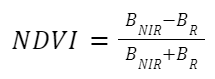

onde, BNIR se refere aos valores da banda do infravermelho próximo e BR do vermelho.


*GOWARD, Samuel N. et al. Normalized difference vegetation index measurements from the Advanced Very High Resolution Radiometer. Remote sensing of environment, v. 35, n. 2-3, p. 257-277, 1991.
HUETE, Alfredo et al. Overview of the radiometric and biophysical performance of the MODIS vegetation indices. Remote sensing of environment, v. 83, n. 1-2, p. 195-213, 2002.*

&nbsp;

####**NDWI**
O **Normalized Difference Water Index (NDWI)** se propõe a mensurar a radiação que interage com as moléculas líquidas presentes na vegetação. Duas bandas espectrais são relacionadas, a do infravermelho próximo e a do verde. A absorção da água é alta na região do infravermelho próximo com comportamento de forte reflexão na região do verde. Tais características são aproveitadas neste índice, calculado pela seguinte equação:

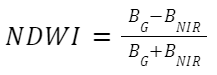

onde, BG se refere aos valores da banda do verde e BNIR do infravermelho próximo.


*GAO, Bo-Cai. NDWI—A normalized difference water index for remote sensing of vegetation liquid water from space. Remote sensing of environment, v. 58, n. 3, p. 257-266, 1996.
KHALID, Hafiza Wajiha; KHALIL, Rao M. Zahid; QURESHI, Muhammad Ateeq. Evaluating spectral indices for water bodies extraction in western Tibetan Plateau. The Egyptian Journal of Remote Sensing and Space Science, v. 24, n. 3, p. 619-634, 2021.*

&nbsp;

####**EVI**
O **Enhanced Vegetation Index (EVI)** foi desenvolvido para otimizar o sinal de vegetação com sensibilidade aprimorada em regiões de alta biomassa e melhora do monitoramento de vegetação por meio de um desacoplamento do sinal de fundo do dossel e redução nas influências atmosféricas. Para seu cálculo, utiliza-se, preferencialmente, reflectâncias de superfície corrigidas atmosfericamente ou parcialmente corrigidas (absorção de Rayleigh e ozônio). Seu cálculo é obtido pela seguinte equação:

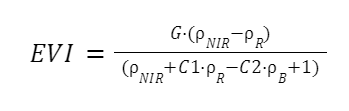
	
onde, NIR se refere a reflectância corrigida da banda do infravermelho próximo, e R a do vermelho e B do azul. L é o ajuste de fundo do dossel, associado a transferência radiante não linear e diferencial nas regiões do infravermelho próximo e do vermelho através de um dossel. C1, C2 são os coeficientes do termo de resistência a aerossóis, que usa a faixa azul para corrigir influências de aerossóis na faixa vermelha. Os coeficientes adotados no algoritmo EVI podem ser dados por: L=1, C1=6, C2=7,5 e G (fator de ganho)=2,5.
A faixa de valores para EVI é de –1 a +1, e para vegetação saudável, varia entre 0,2 e 0,8.

*HUETE, Alfredo et al. Overview of the radiometric and biophysical performance of the MODIS vegetation indices. Remote sensing of environment, v. 83, n. 1-2, p. 195-213, 2002.
HUETE, Alfredo; JUSTICE, C.; LIU, H. Development of vegetation and soil indices for MODIS-EOS. Remote Sensing of environment, v. 49, n. 3, p. 224-234, 1994.*

&nbsp;

###**SAVI**
O Índice de Vegetação Ajustado ao Solo **Soil Adjusted Vegetation Index (SAVI)** é um índice que leva em consideração os efeitos do solo exposto nas imagens analisadas, para ajuste do NDVI quando a superfície não está completamente coberta pela vegetação.
O SAVI foi considerado um passo importante para o estabelecimento de “lobal” simples que pode descrever sistemas dinâmicos de solo-vegetação a partir de dados de sensoriamento remoto.

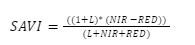

*HUETE, Alfredo R. A soil-adjusted vegetation index (SAVI). Remote sensing of environment, v. 25, n. 3, p. 295-309, 1988.*

&nbsp;

###**NPCI**
O índice de razão de clorofila de pigmento normalizado **normalized pigment chlorophyll ratio Index (NPCI)** faz a avaliação do teor de clorofila das copas das culturas incluiu o pigmento normalizado
Índice de razão de clorofila (NPCI)A forma deste índice é semelhante ao NDVI.

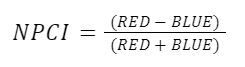

*HATFIELD, Jerry L.; PRUEGER, John H. Value of using different vegetative indices to quantify agricultural crop characteristics at different growth stages under varying management practices. Remote Sensing, v. 2, n. 2, p. 562-578, 2010.*

&nbsp;

####**SR**
A razão simples **Simple Ratio (SR)** é uma razão entre a refletância registrada nas bandas do infravermelho próximo (NIR) e do vermelho. Esta é uma maneira rápida de distinguir folhas verdes de outros objetos na cena e estimar a biomassa relativa presente na imagem. Além disso, este valor pode ser muito útil para distinguir vegetação estressada de áreas não estressadas.
De acordo com a assinatura espectral das folhas verdes, elas exibem refletância muito baixa nas regiões vermelha e azul (as folhas refletem mais na região verde e, portanto, parecem verdes). No entanto, a refletância é relativamente maior na região NIR. Assim, o valor SR é próximo de 1 quando o objeto tem refletância semelhante nas bandas vermelha e NIR – por exemplo, solo. Considerando que, para um objeto verde, o valor seria muito maior que 1.

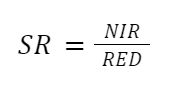

*MELILLOS, George; HADJIMITSIS, Diofantos G. Using simple ratio (SR) vegetation index to detect deep man-made infrastructures in Cyprus. In: Detection and Sensing of Mines, Explosive Objects, and Obscured Targets XXV. International Society for Optics and Photonics, 2020. p. 114180E.*

&nbsp;

####**GLI**
O **Green Leaf Index (GLI)** é um índice espectral utilizado em classificação de imagens para análise do conteúdo de vegetação presente em determinada área. Tal índice se baseia no fato de que os pixels associados ao RGB digital de imagens de folhas e caules de plantas expressam maiores valores na banda verde do que nas do vermelho ou do azul. Solo, rochas, e folhas mortas tendem a ter valores mais baixos para verde do que para vermelho ou azul. Isso é esperado, uma vez que a clorofila absorve luz vermelha (centrado em cerca de 0,67µm) e azul (centrado em cerca de 0,45µm), enquanto reflete a verde (centrado em cerca de 0,55µm). Dessa forma, os números digitais racionados pela seguinte fórmula:

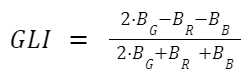

onde, BG se refere aos valores da banda do verde, BR do vermelho e BB do azul.
Em geral, a imagem resultante possui valores de pixel entre -1 e +1. Os valores negativos tendem a ser solo/não-vivo enquanto os valores positivos seriam folhas verdes e caules. Na maioria dos casos, pode-se limitar com um valor próximo de 0 para separar o imagem em duas classes: folhas verdes e solo/sem vida. Porém, devido a condições ambientais esse limiar nem sempre está em zero e deve-se calcular um novo limite. Nesta ferramenta, utilizou-se o método de classificação de quebras naturais de Jenks para dividir os pixels nas duas classes de interesse.

*Hunt, E.R. et al. Remote sensing leaf chlorophyll content using a visible band index. Agronomy Journal, 103 (2011), pp. 1090-1099, 10.2134/agronj2010.0395
Louhaichi, M., M.M. Borman, and D.E. Johnson. 2001. Spatially located platform and aerial photography for documentation of grazing impacts on wheat. Geocarto Int.16:65–70. doi:10.1080/10106040108542184*



## INDEX CALC

### NDVI 


In [ ]:
def calc_ndvi(red_band, nir_band):
  delta = 0.0000000001
  ndvi = (nir_band - red_band) / (nir_band + red_band + delta)
  return ndvi

### NDWI 

In [ ]:
def calc_ndwi(green_band, nir_band):
  delta = 0.0000000001
  ndwi = (green_band - nir_band) / (green_band + nir_band + delta)
  return ndwi

### EVI 

In [ ]:
def calc_evi(nir_band, red_band, blue_band):
  evi = (2.5 * (nir_band - red_band)) / (nir_band + (6 * red_band) - (7.5 * blue_band) + 1)
  return evi

### SAVI 

In [ ]:
def calc_savi(nir_band, red_band, L):
  L = 0.5
  savi = ((1 + L) * (nir_band - red_band)) / (L + nir_band + red_band)
  return savi

###NPCI


In [ ]:
def calc_npci(red_band, blue_band):
  npci = (red_band - blue_band) / (red_band + blue_band)
  return npci

###SR (Simple Ratio)

In [ ]:
def calc_sr(nir_band, red_band):
  sr = nir_band / red_band
  return sr

###Green leaf index

In [ ]:
def calc_gli(green_band, red_band, blue_band):
  delta=0.000001
  gli = (2 * green_band - red_band - blue_band) / (2 * green_band + red_band + blue_band + delta)
  return gli

## PLOTS DEFINITION


In [ ]:
#função definida com o propósito de identificar e retirar os outliers da imagem

def reject_outliers(data, m=1):
    stdev = np.std(data)
    mean = np.mean(data)
    maskMin = mean - stdev * m
    maskMax = mean + stdev * m
    mask = np.ma.masked_outside(data, maskMin, maskMax)
    return mask

### NDVI

In [ ]:
# Plot do indice que o usuário escolheu

def plot_ndvi(red_band, nir_band, xmin, xmax, ymax, ymin):

    ndvi = calc_ndvi(red_band, nir_band)
    ndvi_map = plt.figure(figsize=(25, 9))

    plt.subplot(131)
    plt.title("NDVI")
    plt.imshow(ndvi, extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
    plt.colorbar()

    ndvi_labeled = ndvi.copy()
    ndvi_labeled[ndvi < 0.2] = 0 # < 0.2
    ndvi_labeled[ndvi >= 0.2] = 1 # 0.2 - 0.45
    ndvi_labeled[ndvi >= 0.45] = 2 # >= 0.45
    plt.subplot(132)
    plt.title("NDVI CLASSIFIED")
    colormap_3classes = plt.get_cmap('Greens', 3)
    plt.imshow(ndvi_labeled, extent = (xmin, xmax, ymax, ymin), cmap=colormap_3classes)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Histogram")
    plt.hist(ndvi.ravel(), bins=75)
    
    return ndvi_map

### NDWI

In [ ]:
def plot_ndwi(green_band, nir_band, xmin, xmax, ymax, ymin):

    ndwi = calc_ndwi(green_band, nir_band)
    ndwi_map = plt.figure(figsize=(25, 9))

    plt.subplot(131)
    plt.title("NDWI")
    plt.imshow(calc_ndwi(green_band, nir_band), extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
    plt.colorbar()

    ndwi_list = np.unique(ndwi)

    classes = jenkspy.jenks_breaks(ndwi_list, nb_class=3)

    ndwi_classificacao = np.where(ndwi < classes[1], 0, np.where(ndwi < classes[2], 1, 2))

    plt.subplot(132)
    plt.title("NDWI CLASSIFIED")
    colormap_3classes = plt.get_cmap('Blues', 3)
    plt.imshow(ndwi_classificacao, extent = (xmin, xmax, ymax, ymin), cmap=colormap_3classes)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Histogram")
    plt.hist(ndwi.ravel(), bins=75)

    return ndwi_map

### EVI

In [ ]:
def plot_evi(nir_band, red_band, blue_band, xmin, xmax, ymax, ymin):

    evi = calc_evi(nir_band, red_band, blue_band)
    evi_map = plt.figure(figsize=(25, 9))

    plt.subplot(131)
    plt.title("EVI")
    plt.imshow(evi, extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
    plt.colorbar()

    evi_labeled = evi.copy()
    evi_labeled[evi < 0.2] = 0 
    evi_labeled[evi >= 0.2] = 1

    plt.subplot(132)
    plt.title("EVI CLASSIFIED")
    colormap_3classes = plt.get_cmap('Greens', 3)
    plt.imshow(evi_labeled, extent = (xmin, xmax, ymax, ymin), cmap=colormap_3classes)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Histogram")
    plt.hist(evi.ravel(), bins=75)
  
    return evi_map

###SAVI


In [ ]:
def plot_savi(nir_band, red_band, xmin, xmax, ymax, ymin, L=0.5):

    savi = calc_savi(nir_band, red_band, L=0.5)
    savi_map = plt.figure(figsize=(25, 9))

    plt.subplot(131)
    plt.title("SAVI")
    plt.imshow(calc_savi(nir_band, red_band, L=0.5), extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
    plt.colorbar()

    savi_list = np.unique(savi)

    classes = jenkspy.jenks_breaks(savi_list, nb_class=5)

    savi_classificacao = np.where(savi < classes[1], 0, np.where(savi < classes[2], 1, np.where(savi < classes[3], 2, np.where(savi < classes[4], 3, 4))))
 
    plt.subplot(132)
    plt.title("SAVI CLASSIFIED")
    colormap_5classes = plt.get_cmap('Greens', 5)
    plt.imshow(savi_classificacao, extent = (xmin, xmax, ymax, ymin), cmap=colormap_5classes)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Histogram")
    plt.hist(savi.ravel(), bins=75)  

    return savi_map

###NPCI

In [ ]:
def plot_npci(red_band, blue_band, xmin, xmax, ymax, ymin):

    npci = calc_npci(red_band, blue_band)
    npci_map = plt.figure(figsize=(25, 9))

    plt.subplot(131)
    plt.title("NPCI")
    plt.imshow(calc_npci(red_band, blue_band), extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
    plt.colorbar()

    npci_list = np.unique(npci)

    classes = jenkspy.jenks_breaks(npci_list, nb_class=5)

    npci_classificacao = np.where(npci < classes[1], 0, np.where(npci < classes[2], 1, np.where(npci < classes[3], 2, np.where(npci < classes[4], 3, 4))))

    plt.subplot(132)
    plt.title("NPCI CLASSIFIED")
    colormap_5classes = plt.get_cmap('Greens', 5)
    plt.imshow(npci_classificacao, extent = (xmin, xmax, ymax, ymin), cmap=colormap_5classes)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Histogram")
    plt.hist(npci.ravel(), bins=75)
    

    return npci_map

###SR (Simple Ratio)

In [ ]:
def plot_sr(nir_band, red_band, xmin, xmax, ymax, ymin):

     sr = calc_sr(nir_band, red_band)
     sr_map = plt.figure(figsize=(25, 9))

     plt.subplot(131)
     plt.title("SR")
     plt.imshow(calc_sr(nir_band, red_band), extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
     plt.colorbar()

     sr_list = np.unique(sr)

     classes = jenkspy.jenks_breaks(sr_list, nb_class=4)

     sr_classificacao = np.where(sr < classes[1], 0, np.where(sr < classes[2], 1, np.where(sr < classes[3], 2,  3)))

     plt.subplot(132)
     plt.title("SR CLASSIFIED")
     colormap_4classes = plt.get_cmap('Greens', 4)
     plt.imshow(sr_classificacao, extent = (xmin, xmax, ymax, ymin), cmap=colormap_4classes)
     plt.colorbar()
    
     plt.subplot(133)
     plt.title("Histogram")
     plt.hist(sr.ravel(), bins=75)

     return sr_map

###Green leaf index

In [ ]:
def plot_gli(green_band, red_band, blue_band, xmin, xmax, ymax, ymin):

    gli = calc_gli(green_band, red_band, blue_band)
    gli2 = reject_outliers(gli, m=1)
    gli_map = plt.figure(figsize=(25, 9))

    plt.subplot(131)
    plt.title("GLI")
    plt.imshow(gli2, extent = (xmin, xmax, ymax, ymin) , cmap='viridis')
    plt.colorbar()

    gli_list = np.unique(gli2)

    classes = jenkspy.jenks_breaks(gli_list, nb_class=3)

    gli_classificacao = np.where(gli < classes[1], 0, np.where(gli < classes[2], 1, 2))

    plt.subplot(132)
    plt.title("GLI CLASSIFIED")
    colormap_3classes = plt.get_cmap('Greens', 3)
    plt.imshow(gli_classificacao, extent = (xmin, xmax, ymax, ymin), cmap=colormap_3classes)
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Histogram")
    plt.hist(gli2.ravel(), bins=75)

    return gli_map

## INDEX PLOT

Qual índice gostaria de computar?npci


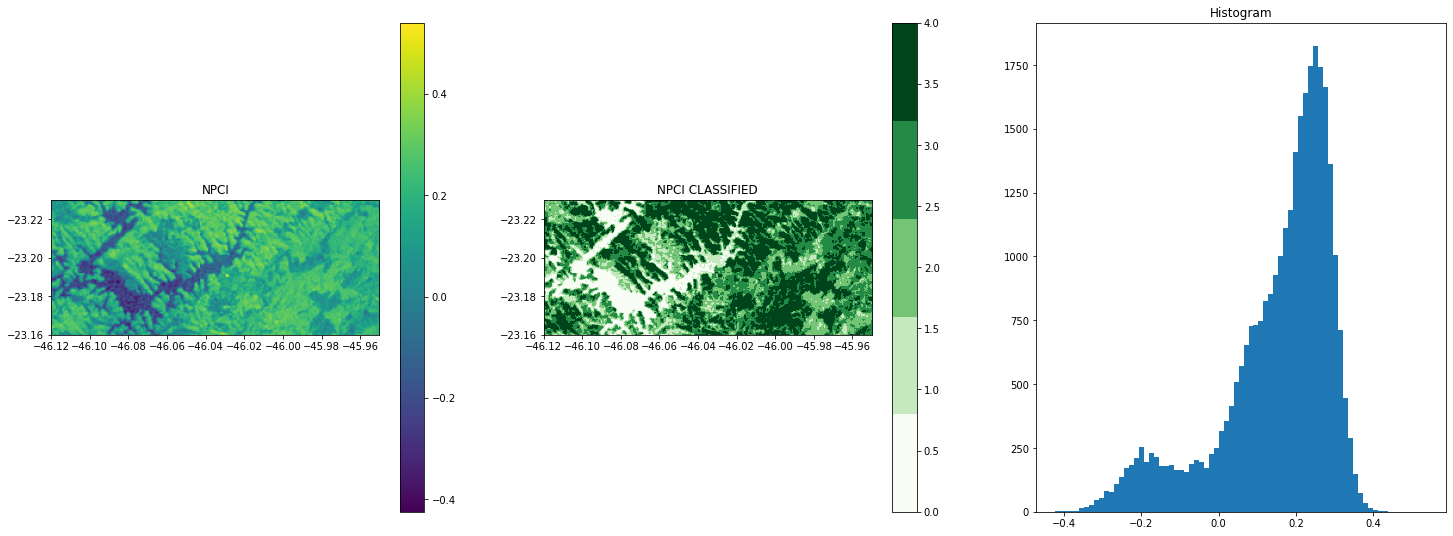

Gostaria de computar outro índice? (s/n): s
Qual índice gostaria de computar?ndvi


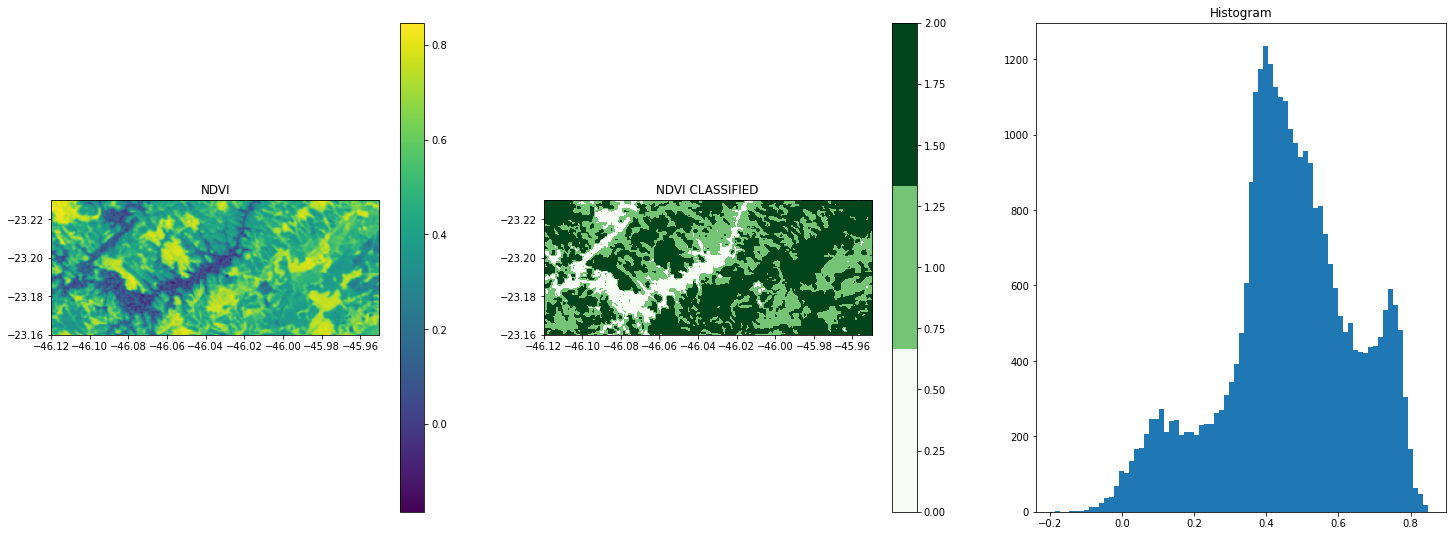

Gostaria de computar outro índice? (s/n): s
Qual índice gostaria de computar?ndwi


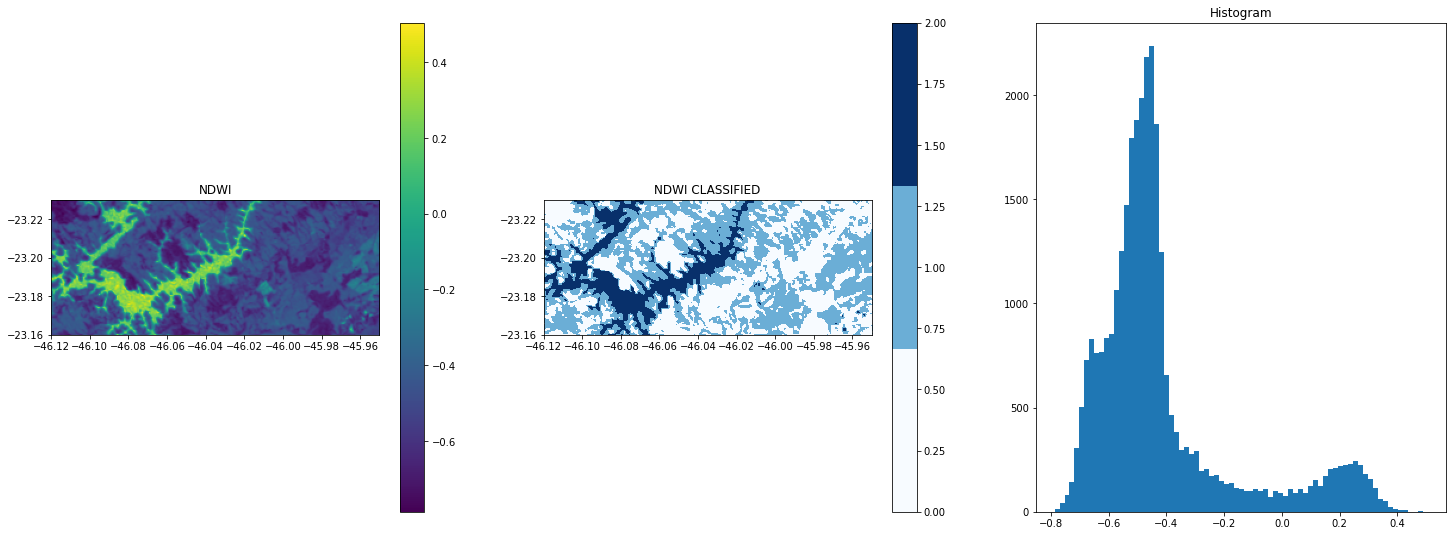

Gostaria de computar outro índice? (s/n): n


In [ ]:
#loop de escolha do indice
opc = 's' #opção sim
res = 'NaN' #opção diferente de sim

while opc.lower() == 's': 
  
  #Pergunta ao usuário qual índice quer computar

  index = str(input('Qual índice gostaria de computar?')).upper()

  if index == 'NDVI':
    plot_ndvi(red_band, nir_band, xmin, xmax, ymax, ymin)
    plt.pause(0.1)

  if index == 'NDWI':
    plot_ndwi(green_band, nir_band, xmin, xmax, ymax, ymin)
    plt.pause(0.1)

  if index == 'EVI':
    plot_evi(nir_band, red_band, blue_band, xmin, xmax, ymax, ymin)
    plt.pause(0.1)

  if index == 'SAVI':
    plot_savi(nir_band, red_band, xmin, xmax, ymax, ymin, L=0.5)
    plt.pause(0.1)

  if index == 'NPCI':
    plot_npci(red_band, blue_band, xmin, xmax, ymax, ymin)
    plt.pause(0.1)

  if index == 'SR':
    plot_sr(nir_band, red_band, xmin, xmax, ymax, ymin)
    plt.pause(0.1)

  if index == 'GLI':
    plot_gli(green_band, red_band, blue_band, xmin, xmax, ymax, ymin)
    plt.pause(0.1)

  opc = input('Gostaria de computar outro índice? (s/n): ')

## FINAL CONSIDERATIONS 

###Melhorias

1. Criar exceções: com a interação com o usuário não criamos exceções caso a input seja insatisfatório;
2. Para  a escolha do limite das listas, seria interessante criarmos uma imagem prévia para cada item, talvez com o dado de cobertura de nuvem; 
3. A velocidade dos plot poderia ser mais rápida;
4. Refatoração do código para deixá-lo mais "limpo";
5. Colocar botões interativos (escolha do satélite, data etc.);
5. Colocar mais índices espectrais;
6. Limitação de disponibilidade de bandas para os sensores escolhidos. 




## AUX

In [ ]:
# todos os saltelites disponiveis
#print('escolha entre as coleções abaixo')

#for collection in service.get_collections():

 #   print(collection)


#from IPython.core.display import display, HTML

#collections_html = ''

#for collection in service.get_collections():
#    collections_html += f'<li>{collection.id}</li>'

#html = f'''<p>STAC</p>
#<ul>
#  <li><b>URL:</b> {service.get_self_href()}</li>
#  <li><b>Collections:</b></li>
#  <ul>
#  {collections_html}
#  </ul>
#</ul>
#'''
#display(HTML(html))

In [ ]:
#informações de todas as bandas desse satélite
#sorted(item.properties['eo:bands'], key=lambda band: band['name'])

#apresentação das bandas
#for k in assets.keys():
#    print(k)